In [1]:
import argparse
import os
import time
import shutil

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

    

import torchvision
import torchvision.transforms as transforms

from models import *   # bring everything in the folder models

global best_prec
use_gpu = torch.cuda.is_available()
print('=> Building model...')
    
    
batch_size = 128

model_name = "cifar10"
model = cifar10()

        

normalize = transforms.Normalize(mean=[0.491, 0.482, 0.447], std=[0.247, 0.243, 0.262])


train_dataset = torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        normalize,
    ]))
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)


test_dataset = torchvision.datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        normalize,
    ]))

testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)


print_freq = 100 # every 100 batches, accuracy printed. Here, each batch includes "batch_size" data points
# CIFAR10 has 50,000 training data, and 10,000 validation data.

def train(trainloader, model, criterion, optimizer, epoch):
    batch_time = AverageMeter()   ## at the begining of each epoch, this should be reset
    data_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()

    model.train()

    end = time.time()  # measure current time
    
    for i, (input, target) in enumerate(trainloader):
        # measure data loading time
        data_time.update(time.time() - end)  # data loading time

        input, target = input.cuda(), target.cuda()

        # compute output
        output = model(input)
        loss = criterion(output, target)

        # measure accuracy and record loss
        prec = accuracy(output, target)[0]
        losses.update(loss.item(), input.size(0))
        top1.update(prec.item(), input.size(0))

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # measure elapsed time
        batch_time.update(time.time() - end) # time spent to process one batch
        end = time.time()


        if i % print_freq == 0:
            print('Epoch: [{0}][{1}/{2}]\t'
                  'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Data {data_time.val:.3f} ({data_time.avg:.3f})\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Prec {top1.val:.3f}% ({top1.avg:.3f}%)'.format(
                   epoch, i, len(trainloader), batch_time=batch_time,
                   data_time=data_time, loss=losses, top1=top1))

            

def validate(val_loader, model, criterion ):
    batch_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()

    # switch to evaluate mode
    model.eval()

    end = time.time()
    with torch.no_grad():
        for i, (input, target) in enumerate(val_loader):
         
            input, target = input.cuda(), target.cuda()

            # compute output
            output = model(input)
            loss = criterion(output, target)

            # measure accuracy and record loss
            prec = accuracy(output, target)[0]
            losses.update(loss.item(), input.size(0))
            top1.update(prec.item(), input.size(0))

            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()

            if i % print_freq == 0:  # This line shows how frequently print out the status. e.g., i%5 => every 5 batch, prints out
                print('Test: [{0}/{1}]\t'
                  'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Prec {top1.val:.3f}% ({top1.avg:.3f}%)'.format(
                   i, len(val_loader), batch_time=batch_time, loss=losses,
                   top1=top1))

    print(' * Prec {top1.avg:.3f}% '.format(top1=top1))
    return top1.avg


def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True) # topk(k, dim=None, largest=True, sorted=True)
                                               # will output (max value, its index)
    pred = pred.t()           # transpose
    correct = pred.eq(target.view(1, -1).expand_as(pred))   # "-1": calculate automatically

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0)  # view(-1): make a flattened 1D tensor
        res.append(correct_k.mul_(100.0 / batch_size))   # correct: size of [maxk, batch_size]
    return res


class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n    ## n is impact factor
        self.count += n
        self.avg = self.sum / self.count

        
def save_checkpoint(state, is_best, fdir):
    filepath = os.path.join(fdir, 'checkpoint.pth')
    torch.save(state, filepath)
    if is_best:
        shutil.copyfile(filepath, os.path.join(fdir, 'model_best.pth.tar'))


def adjust_learning_rate(optimizer, epoch):
    """For resnet, the lr starts from 0.1, and is divided by 10 at 80 and 120 epochs"""
    adjust_list = [150, 225]
    if epoch in adjust_list:
        for param_group in optimizer.param_groups:
            param_group['lr'] = param_group['lr'] * 0.1        

#model = nn.DataParallel(model).cuda()
#all_params = checkpoint['state_dict']
#model.load_state_dict(all_params, strict=False)
#criterion = nn.CrossEntropyLoss().cuda()
#validate(testloader, model, criterion)

=> Building model...
Sequential(
  (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
  (2): ReLU()
  (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
  (5): ReLU()
  (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (7): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
  (9): ReLU()
  (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
  (12): ReLU()
  (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (14): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): Batch

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


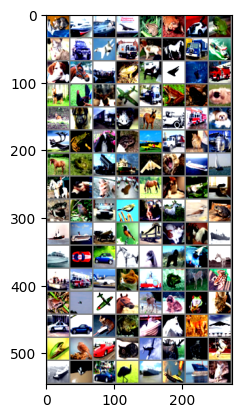

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(testloader)
images, labels = next(dataiter) ## If you run this line, the next data batch is called subsequently.

# show images
imshow(torchvision.utils.make_grid(images))


In [3]:
# This cell is from the website

lr = 4e-2
weight_decay = 1e-4
epochs = 30
best_prec = 0

model = model.cuda()
criterion = nn.CrossEntropyLoss().cuda()
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=weight_decay)
# weight decay: for regularization to prevent overfitting


if not os.path.exists('result'):
    os.makedirs('result')
    
fdir = 'result/'+str(model_name)

if not os.path.exists(fdir):
    os.makedirs(fdir)
        

for epoch in range(0, epochs):
    adjust_learning_rate(optimizer, epoch)

    train(trainloader, model, criterion, optimizer, epoch)
    
    # evaluate on test set
    print("Validation starts")
    prec = validate(testloader, model, criterion)

    # remember best precision and save checkpoint
    is_best = prec > best_prec
    best_prec = max(prec,best_prec)
    print('best acc: {:1f}'.format(best_prec))
    save_checkpoint({
        'epoch': epoch + 1,
        'state_dict': model.state_dict(),
        'best_prec': best_prec,
        'optimizer': optimizer.state_dict(),
    }, is_best, fdir)
    

/home/m7kang/.local/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch: [0][0/391]	Time 4.800 (4.800)	Data 0.349 (0.349)	Loss 2.5567 (2.5567)	Prec 12.500% (12.500%)
Epoch: [0][100/391]	Time 0.061 (0.088)	Data 0.002 (0.005)	Loss 2.8953 (3.4320)	Prec 27.344% (21.689%)
Epoch: [0][200/391]	Time 0.030 (0.063)	Data 0.003 (0.004)	Loss 2.1187 (3.0252)	Prec 33.594% (25.326%)
Epoch: [0][300/391]	Time 0.047 (0.055)	Data 0.002 (0.003)	Loss 1.7593 (2.6362)	Prec 37.500% (28.797%)
Validation starts
Test: [0/79]	Time 0.259 (0.259)	Loss 1.6114 (1.6114)	Prec 38.281% (38.281%)
 * Prec 42.310% 
best acc: 42.310000
Epoch: [1][0/391]	Time 0.271 (0.271)	Data 0.238 (0.238)	Loss 1.4232 (1.4232)	Prec 52.344% (52.344%)
Epoch: [1][100/391]	Time 0.033 (0.041)	Data 0.001 (0.004)	Loss 1.2611 (1.5712)	Prec 47.656% (43.773%)
Epoch: [1][200/391]	Time 0.043 (0.040)	Data 0.002 (0.003)	Loss 1.6478 (1.5092)	Prec 42.188% (46.685%)
Epoch: [1][300/391]	Time 0.060 (0.041)	Data 0.002 (0.003)	Loss 1.2560 (1.4684)	Prec 53.906% (48.518%)
Validation starts
Test: [0/79]	Time 0.267 (0.267)	Loss 1.

Epoch: [15][200/391]	Time 0.035 (0.041)	Data 0.002 (0.003)	Loss 0.4062 (0.3079)	Prec 85.938% (89.525%)
Epoch: [15][300/391]	Time 0.038 (0.040)	Data 0.002 (0.003)	Loss 0.3432 (0.3081)	Prec 88.281% (89.483%)
Validation starts
Test: [0/79]	Time 0.256 (0.256)	Loss 0.2718 (0.2718)	Prec 90.625% (90.625%)
 * Prec 85.680% 
best acc: 86.320000
Epoch: [16][0/391]	Time 0.287 (0.287)	Data 0.267 (0.267)	Loss 0.2107 (0.2107)	Prec 92.188% (92.188%)
Epoch: [16][100/391]	Time 0.062 (0.043)	Data 0.003 (0.005)	Loss 0.3209 (0.2765)	Prec 93.750% (90.579%)
Epoch: [16][200/391]	Time 0.032 (0.041)	Data 0.002 (0.003)	Loss 0.2810 (0.2924)	Prec 86.719% (89.914%)
Epoch: [16][300/391]	Time 0.043 (0.040)	Data 0.002 (0.003)	Loss 0.3977 (0.2989)	Prec 87.500% (89.691%)
Validation starts
Test: [0/79]	Time 0.232 (0.232)	Loss 0.3082 (0.3082)	Prec 90.625% (90.625%)
 * Prec 86.620% 
best acc: 86.620000
Epoch: [17][0/391]	Time 0.314 (0.314)	Data 0.279 (0.279)	Loss 0.3314 (0.3314)	Prec 89.844% (89.844%)
Epoch: [17][100/391]	

In [4]:

fdir = 'result/'+str(model_name)+'/model_best.pth.tar'

checkpoint = torch.load(fdir)
model.load_state_dict(checkpoint['state_dict'])


criterion = nn.CrossEntropyLoss().cuda()

model.eval()
model.cuda()


prec = validate(testloader, model, criterion)


Test: [0/79]	Time 0.319 (0.319)	Loss 0.2197 (0.2197)	Prec 93.750% (93.750%)
 * Prec 88.950% 


In [ ]:
# HW

#  1. train resnet20 and vgg16 to achieve >90% accuracy 
#  2. save your trained model in the result folder 
#  3. Restart your jupyter notebook by "Kernel - Restart & Clear Output"
#  4. Load your saved model for vgg16 and validate to see the accuracy
#  5. such as the last part of "[W2S2_example2]_CNN_for_MNIST.ipynb", prehook the input layers of all the conv layers.
#  6. from the first prehooked input, compute to get the second prehooked input. 
#  7. Compare your computed second input vs. the prehooked second input.
